In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [15]:
# Step 1: Load the Datasets
data1A = pd.read_csv("/Users/book_kuno/Downloads/DDoS 2018/02-20-2018.csv", low_memory=False)
data2A = pd.read_csv("/Users/book_kuno/Downloads/DDoS 2018/02-21-2018.csv", low_memory=False)

#-----------Customized part for each particular datasets--------------
# List of columns to drop
columns_to_drop = ['Flow ID', 'Src Port', 'Src IP', 'Dst IP']
# Drop the specified columns from data1
data1AD = data1A.drop(columns=columns_to_drop, errors='ignore')
# # Randomly sample 1/10 of the data
data1 = data1AD.sample(frac=0.01, random_state=42)  # frac=0.1 means 10%, random_state ensures reproducibility
print(data1.head())
data2 = data2A.sample(frac=0.1, random_state=42)  # frac=0.1 means 10%, random_state ensures reproducibility
print(data2.head())
#-----------Customized part for each particular datasets--------------

         Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
2580950      3389         6  20/02/2018 10:06:56        3556758             9   
3347126     55218         6  20/02/2018 04:35:42             15             2   
7911667      3389         6  20/02/2018 12:00:04        1414684             8   
7091525      3389         6  20/02/2018 04:20:29        5703924            10   
2325195        80         6  20/02/2018 09:31:25            778             3   

         Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
2580950             8           1144.0           1581.0            677.0   
3347126             0              0.0              0.0              0.0   
7911667             7           1144.0           1581.0            677.0   
7091525             8           1052.0           1429.0            581.0   
2325195             4            161.0            488.0            161.0   

         Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active 

In [16]:
# Step 2: Preprocess the Data
def preprocess_data(data):
    data.columns = data.columns.str.strip()
    data = data.dropna()
    
    # Encode the target column ('Label')
    encoder = LabelEncoder()
    data['Label'] = encoder.fit_transform(data['Label'])
    
    # Select only numeric columns for scaling
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns.remove('Label')  # Exclude the target column
    
    # Check for infinite or extremely large values
    data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)
    data = data.dropna(subset=numeric_columns)
    
    # Scale the numeric feature columns
    scaler = StandardScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
    
    X = data[numeric_columns]
    y = data['Label']
    
    # Update the return statement to include the encoder
    return X, y, encoder

# X1, y1 = preprocess_data(data1)
# X2, y2 = preprocess_data(data2)
X1, y1, encoder1 = preprocess_data(data1)
X2, y2, encoder2 = preprocess_data(data2)

/var/folders/r9/g1ll_nxx2n70f0475ch9wkyr0000gn/T/ipykernel_24279/2150753753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = encoder.fit_transform(data['Label'])
/var/folders/r9/g1ll_nxx2n70f0475ch9wkyr0000gn/T/ipykernel_24279/2150753753.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)


In [17]:
# Step 3: Split the Training Data
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [18]:
# Step 4: Train the Linear SVM
svm_model = SVC(kernel='linear', C=100, class_weight='balanced')
#function is used to create an SVM classifier (from scikit-learn)
svm_model.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', kernel='linear')

In [19]:
# Step 5: Validate the Model
y_val_pred = svm_model.predict(X_val)
print("Validation Results")
print(classification_report(y_val, y_val_pred))

Validation Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21977
           1       0.97      1.00      0.99      1681

    accuracy                           1.00     23658
   macro avg       0.99      1.00      0.99     23658
weighted avg       1.00      1.00      1.00     23658



In [20]:
# # Step 6: Hyperparameter Tuning (Optional)
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear']
# }
# grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)

In [21]:
# Step 7: Test the Model
y_test_pred = svm_model.predict(X2)
print("Test Results")
print(confusion_matrix(y2, y_test_pred))
print(classification_report(y2, y_test_pred))
print("Accuracy:", accuracy_score(y2, y_test_pred))

Test Results
[[35787    42     0]
 [15727 53127     0]
 [    0   175     0]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     35829
           1       1.00      0.77      0.87     68854
           2       0.00      0.00      0.00       175

    accuracy                           0.85    104858
   macro avg       0.56      0.59      0.56    104858
weighted avg       0.89      0.85      0.85    104858

Accuracy: 0.8479467470293158


/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


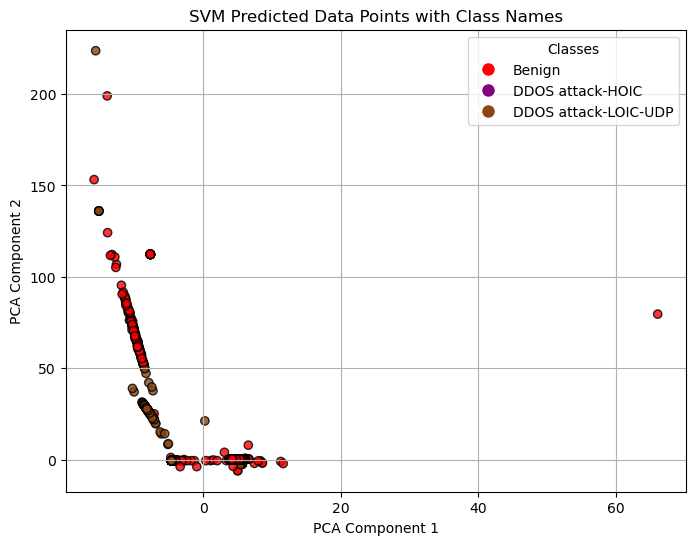

" \nUnderstanding the Graph\n1)Axes:\nThe x-axis represents the first principal component (PC1).\nThe y-axis represents the second principal component (PC2).\n2)Data Points:\nEach point on the graph represents an observation (e.g., a sample or a data point) in your dataset.\nThe position of each point is determined by its scores on PC1 and PC2.\n3)Variance:\nPC1 captures the maximum variance in the data, meaning it explains the largest amount of variability.\nPC2 captures the second most variance, orthogonal to PC1, meaning it explains the next largest amount of variability without overlapping with PC1.\n\nInterpreting the Graph\n1)Clusters:If the points form distinct clusters, this suggests that there are natural groupings in your data. These clusters can indicate different categories or classes within your dataset.\n2)Spread:The spread of points along PC1 and PC2 indicates how much variance each component explains. A wide spread along PC1 means it captures a lot of the data's variabi

In [22]:
# Step 8: Plot the Predicted Data Points with Class Names
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import numpy as np

def plot_predicted_data_with_class_names(X, y_true, y_pred, encoder, title="Predicted Data Points"):
    # Reduce dimensionality to 2D for visualization using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Get all possible class labels from the test data and predictions
    all_classes = np.union1d(np.unique(y_true), np.unique(y_pred))
    class_names = encoder.inverse_transform(all_classes)
    
    # Define a color map for all possible classes
    cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00', '#FFA500', '#800080', '#FFFF00', '#00FFFF', '#8B4513'])  # Add more colors if needed
    num_classes = len(all_classes)
    
    # Create a scatter plot with predicted labels
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap=cm_bright, edgecolor='k', alpha=0.8)
    
    # Add a legend with class names
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=cm_bright(i / (num_classes - 1)), markersize=10)
               for i in range(num_classes)]
    plt.legend(handles, class_names, title="Classes", loc="best")
    
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# Assuming X2, y2 (true test labels), y_test_pred (predictions), and encoder2 are already defined
plot_predicted_data_with_class_names(X2, y2, y_test_pred, encoder2, title="SVM Predicted Data Points with Class Names")

''' 
Understanding the Graph
1)Axes:
The x-axis represents the first principal component (PC1).
The y-axis represents the second principal component (PC2).
2)Data Points:
Each point on the graph represents an observation (e.g., a sample or a data point) in your dataset.
The position of each point is determined by its scores on PC1 and PC2.
3)Variance:
PC1 captures the maximum variance in the data, meaning it explains the largest amount of variability.
PC2 captures the second most variance, orthogonal to PC1, meaning it explains the next largest amount of variability without overlapping with PC1.

Interpreting the Graph
1)Clusters:If the points form distinct clusters, this suggests that there are natural groupings in your data. These clusters can indicate different categories or classes within your dataset.
2)Spread:The spread of points along PC1 and PC2 indicates how much variance each component explains. A wide spread along PC1 means it captures a lot of the data's variability.
3)Direction:The direction of the spread can give insights into the relationships between variables. For example, if points are spread diagonally, it suggests that the original variables contributing to PC1 and PC2 are correlated.
4)Outliers:Points that are far from the main cluster can be outliers. These observations might have unique characteristics or errors.
'''

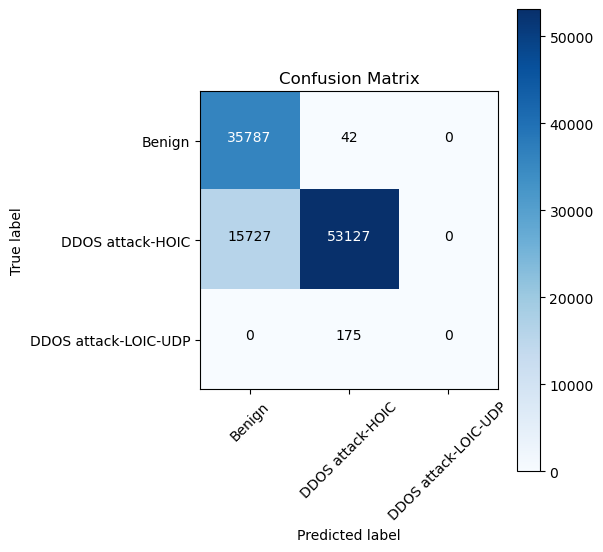

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

# Step 9: Confusion Matrix Visualization
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

# Confusion Matrix Plot
cm = confusion_matrix(y2, y_test_pred)
class_names = encoder2.inverse_transform(np.unique(y2))
plot_confusion_matrix(cm, class_names)
